# 创建合成数据
可用的真实地图数量很少(最多1000个示例)。为了克服这一困难，利用模拟数据对卷积神经网络进行训练和验证。

## 导入模块

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
%matplotlib inline

import os
from sklearn.utils import shuffle 
import random
from skimage import draw
import pandas as pd
from scipy import ndimage
import cv2 

from PIL import Image

import seaborn as sns
sns.set()

from tqdm import tqdm

#%matplotlib notebook
np.set_printoptions(suppress=True)  # 禁止打印多余信息

In [2]:
os.getcwd()

'/home/jiajianhao/文档/cnn/Magnetic_methods-master/YOLO/Synthetic_data/data/split'

In [3]:
# from My_Utils import * # all the functions created that will be useful
# all the functions created that will be useful
from My_Utils_Magnetic_methods import *
from My_Utils import *
# 设置画图语言为雅黑体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False

##  Model


### Model Griding
这段代码创建了一个网格，其中 'zmax' 表示总的网格线数，'map_lenght' 表示地图的长度，以米为单位。然后使用自建的工具模块 `grid` 函数生成 X 和 Y 的坐标(x,y都是-25到25,共100个值)


In [4]:
grid_caracteristic = {

    'zmax': 100,  # Total number of grid lines
    # [m] Our grid will be between (-map_lenght,map_lenght) because our anomalie is centered in (0,0)
    'map_lenght': 25
}  # 网格属性

zmax = grid_caracteristic['zmax']
map_lenght = grid_caracteristic['map_lenght']

X, Y = grid(zmax, map_lenght)  # X and Y in [meters]

print(f'X array shape: {X.shape}')
print(f'Y array shape: {Y.shape}')
print(f'Cell lenght: {(map_lenght*2)/zmax}')

X array shape: (100, 1)
Y array shape: (1, 100)
Cell lenght: 0.5



### Latitudes



使用 `latitudes_array` 函数生成相应的纬度数组（以度和弧度表示），以及倾斜角（Inclination）的数组。


In [5]:
lat_dict = {

    'lat_min': 0,  # [°]
    'lat_max': 120,  # [°]
    'lat_frequency': 30,  # [°]

}

lat_array, lat_array_rad, I = latitudes_array(
    lat_dict['lat_min'], lat_dict['lat_max'], lat_dict['lat_frequency'])

print(f'Latitudes: {lat_array} [°]')  # °
print(f'Latitudes: {np.round(lat_array_rad, decimals=2)} [rad]')  # 弧度制
print(f'Inclinaison: {np.round(I, decimals=2)} [rad]')  # 倾角

Latitudes: [ 0 30 60 90] [°]
Latitudes: [0.   0.52 1.05 1.57] [rad]
Inclinaison: [0.   0.86 1.29 1.57] [rad]



## Defining anomalies physical characteristics



这段代码定义了一些物理参数

In [6]:
r_v_d_dict = {

    'Br': 47000,  # Champ local(nT)
    'r_min': 0.05,  # [meters]
    'r_max': 0.09,  # [meters]
    'eAboughtLAndR': 4,
    'r_frequency': 0.01,  # [meters]
    'h_min': 1.0,  # [meters]
    'h_max': 1.8,  # [meters]
    'h_frequency': 0.2,  # [meters]


}

Br = r_v_d_dict['Br']
r_min = r_v_d_dict['r_min']
r_max = r_v_d_dict['r_max']
eAboughtLAndR = r_v_d_dict['eAboughtLAndR']
r_frequency = r_v_d_dict['r_frequency']
h_min = r_v_d_dict['h_min']
h_max = r_v_d_dict['h_max']
h_frequency = r_v_d_dict['h_frequency']
# position = np.array(
#     np.mat('0 0 0;60 0 0'))
# position = np.array(
#     np.mat('0 0 0;30 0 0;60 0 0;60 180 0;60 270 0;90 0 60;90 0 180;0 120 0;0 90 0'))
theta_range = [0,30,60,90]
theta_frequency = 30
phi_range = [0,90,120,180]
phi_frequency = 90
gama_range = [0,60,120,180]
r_array = np.arange(r_min, r_max, r_frequency)
numberOfPosition = len(theta_range)*len(phi_range)*len(gama_range)
position = np.zeros((numberOfPosition,3))
count = 0
for theta in theta_range:
    for phi in phi_range:
        for gama in gama_range:
            position[count,:] = gama,theta,phi
            count+=1


r_array, V_array, h_array, n_examples, Parameters_array = r_V_h_array(r_min, r_max, r_frequency, eAboughtLAndR,
                                                                      h_min, h_max, h_frequency, position,
                                                                      zmax, Br)
L_array = eAboughtLAndR*r_array

# Last 3 examples
print(f'Radius: {np.round(r_array[:], decimals=3)} [meters]')
print(f'Volume: {V_array[:]} [m^3]')  # Last 3 examples
print(f'Number of V: {V_array.shape[0]}')  # Last 3 examples
print("---------------------------------------------")
# Last 3 examples
print(f'Depth: {np.round(h_array[:], decimals = 2)} [meters]')
print(f'Number of h: {h_array.shape[0]}')  # Last 3 examples
print("---------------------------------------------")
print(f'Number of examples: {n_examples}')
print(f'Parameters array shape: {Parameters_array.shape} ')

Radius: [0.05 0.06 0.07 0.08] [meters]
Volume: [0.002 0.004 0.006 0.009] [m^3]
Number of V: 4
---------------------------------------------
Depth: [1.  1.2 1.4 1.6] [meters]
Number of h: 4
---------------------------------------------
Number of examples: 1024
Parameters array shape: (1024, 5) 


<a name='4'></a>
## 4.  Creating X and Y array 

<a name='4.1'></a>
### 4.1 Raw data (before data augmetation在数据增强之前)



这个函数似乎用于计算垂直方向上的磁感应强度。它通过对每个经度的不同纬度值进行迭代，计算在每个网格点上的磁感应强度。

函数的输入包括磁场强度（'Br'）、磁矩（'m'）、倾斜角（'I'）、X、Y、深度（'h'）、传感器的底部和顶部高度（'H_capteur_bas'和'H_capteur_haut'）、纬度数量（'N_lat'）、示例数量（'examples'）、网格数量（'zmax'）、参数数量（'n_parameters'）、以及纬度的弧度表示和参数数组。

该函数的输出包括一个包含磁感应强度值的三维数组（'X_array_raw'）和一个包含体积和深度值的三维数组（'Parameters_array_raw'）。


In [7]:
# Capteur type fluxgate, on calcule la composante verticale

def X_array_raw(map_lenght, eAboughtLAndR,N_lat, examples,
                zmax, n_parameters, lat_array, Parameters_array):

    X_array_raw = np.zeros((N_lat, examples, zmax, zmax))  # 初始化磁感应值数组
    Parameters_array_raw = np.zeros((N_lat, examples, n_parameters))  # 初始化参数数组


    i = 0

    for i_lat in lat_array:  # 遍历纬度弧度
        Parameters_array_raw[i, :, :] = Parameters_array[:, :]
        for i_example in range(examples):
            r = round(Parameters_array[i_example,0],2)
            L = round(eAboughtLAndR * r,2)
            z = round(Parameters_array[i_example,1],2)
            gama,theta,phi = Parameters_array[i_example,2:]
            print(i_lat,i_example,r,L,z,gama,theta,phi)
            # X_array_raw[i,i_example, :, :] = MyModel().F
            X_array_raw[i,i_example, :, :] = MyModel(map_lenght, zmax, L, r,r ,gama,theta,phi,0,0,z=z,I=i_lat,D=0).F
        i =i + 1

    return X_array_raw, Parameters_array_raw

In [8]:
### X_data array, Calculating Induction magnétique de l'Anomalie [nT] ###

X_Y_array_dict = {
    'N_latitudes': lat_array.shape[0],  # Number of latitudes
    'N_parameters': Parameters_array.shape[1]  # Number of parameters
}

N_latitudes = X_Y_array_dict["N_latitudes"]
N_parameters = X_Y_array_dict["N_parameters"]

In [9]:
# X_data_array_raw, Parameters_array_raw = X_array_raw(map_lenght,eAboughtLAndR , N_latitudes,
#                                                      n_examples, zmax, N_parameters,
#                                                      lat_array, Parameters_array)

# print(f'X array raw shape: {X_data_array_raw.shape}')
# print(f'Parameters array raw shape: {Parameters_array_raw.shape}')
# # 存储
# np.save(file="./data/X_data_array_raw768.npy", arr=X_data_array_raw)
# np.save(file="./data/Parameters_array_raw768.npy", arr=Parameters_array_raw)

In [10]:
theta_range1 = theta_range
def add_all_data(theta_range1):
    X_data_array_raw = np.zeros((4,int(256*len(theta_range1)),100,100))
    Parameters_array = np.zeros((4,int(256*len(theta_range1)),5))
    for theta_range_num in theta_range1:
        X_data_array_raw_1 = np.load(
            file="./X_data_array_raw768_"+str(theta_range_num)+".npy")
        Parameters_array_1 = np.load(
            file="./Parameters_array_raw768_"+str(theta_range_num)+".npy")
        start = int(theta_range_num/30*256)
        print
        end = int(theta_range_num/30*256+256)
        X_data_array_raw[:,start:end,:,:]= X_data_array_raw_1
        Parameters_array[:,start:end,:] = Parameters_array_1
    return X_data_array_raw, Parameters_array
for theta_range_num in theta_range1:
    X_data_array_raw = np.load(
        file="./X_data_array_raw768_"+str(theta_range_num)+".npy")
    Parameters_array_raw = np.load(
        file="./Parameters_array_raw768_"+str(theta_range_num)+".npy")


In [11]:
X_data_array_raw,Parameters_array_raw = add_all_data(theta_range1)

In [12]:
print(X_data_array_raw.shape)
print(Parameters_array_raw.shape)

(4, 1024, 100, 100)
(4, 1024, 5)


In [13]:
par_window = 64  # 24 to have a better look

diff_max = int((zmax + par_window) / 2)
diff_min = int((zmax - par_window) / 2)

X_data_array_raw_2 = X_data_array_raw[:,:, diff_min:diff_max, diff_min:diff_max]

print(X_data_array_raw_2.shape)

(4, 1024, 64, 64)


Plotting model: 10


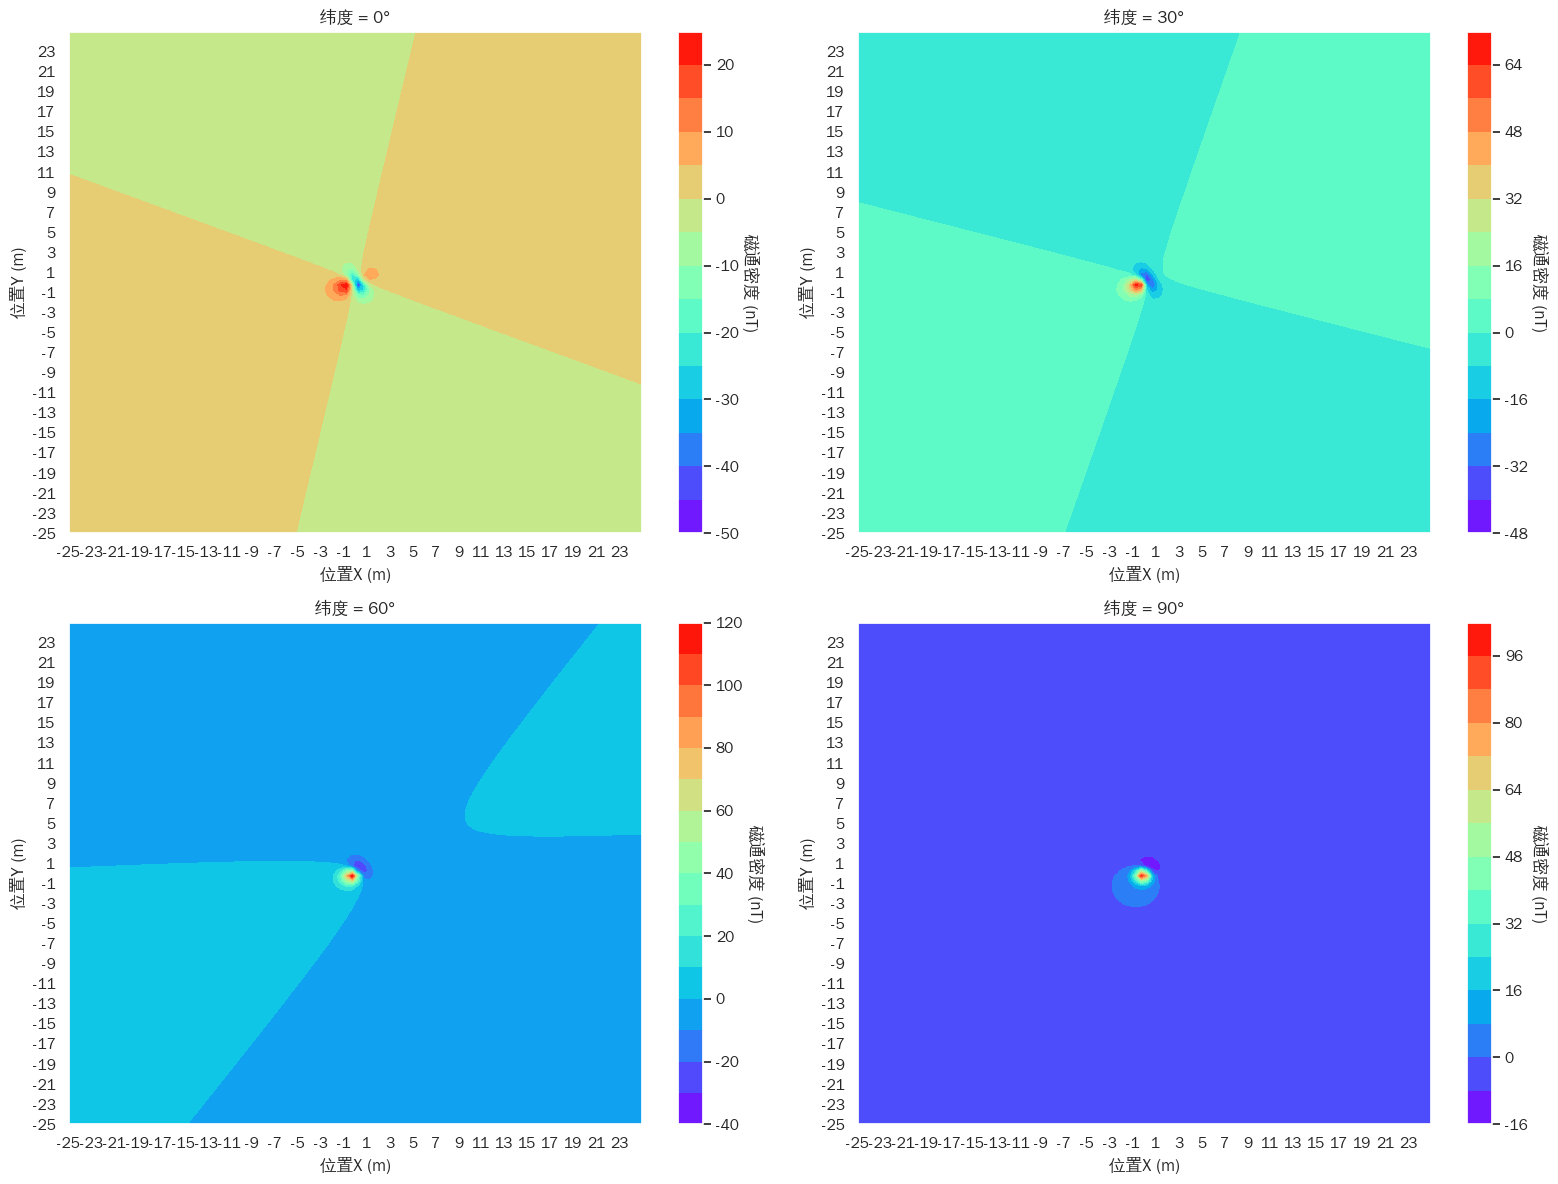

In [14]:
Raw_visualization_dict = {

    'height': 16,
    'width': 12,
    'n_model_aug': None,  # Not yet
    'n_dipoles': None,  # Not yet

}

height = Raw_visualization_dict['height']
width = Raw_visualization_dict['width']
n_model_aug = Raw_visualization_dict['n_model_aug']
n_dipoles = Raw_visualization_dict['n_dipoles']

rows = 2
cols = 2

example_to_plot = 10

par_window = 100

Plot_X_array_raw(map_lenght, height, width, example_to_plot, lat_array, X_data_array_raw,
                 Parameters_array_raw, n_model_aug, n_dipoles, rows, cols, par_window)

### rearranging database shape

In [15]:
print(X_data_array_raw.shape)
print(X_data_array_raw_2.shape)
print(Parameters_array_raw.shape)

(4, 1024, 100, 100)
(4, 1024, 64, 64)
(4, 1024, 5)


In [16]:
random_seed_2 = 10

for lat_i in tqdm(range(X_data_array_raw.shape[0])):

    X_data_array_raw_2[lat_i, :] = shuffle(
        X_data_array_raw_2[lat_i, :], random_state=random_seed_2)
    Parameters_array_raw[lat_i, :] = shuffle(
        Parameters_array_raw[lat_i, :], random_state=random_seed_2)


100%|██████████| 4/4 [00:00<00:00, 37.06it/s]


In [17]:
print(X_data_array_raw.shape)
print(X_data_array_raw_2.shape)
print(Parameters_array_raw.shape)

(4, 1024, 100, 100)
(4, 1024, 64, 64)
(4, 1024, 5)


In [18]:
train_rate = 0.70
dev_rate = 0.25
test_rate = 0.05

examples_t = X_data_array_raw_2.shape[1]

X_train = X_data_array_raw_2[0, :int(examples_t*train_rate), :, :]
Y_pos_train = Parameters_array_raw[0, :int(examples_t*train_rate), :]

X_dev = X_data_array_raw_2[0, int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)), :, :]
Y_pos_dev = Parameters_array_raw[0, int(examples_t*train_rate)
                              :int(examples_t*(train_rate+dev_rate)), :]

X_test = X_data_array_raw_2[0, int(examples_t*(train_rate+dev_rate)):, :, :]
Y_pos_test = Parameters_array_raw[0, int(examples_t*(train_rate+dev_rate)):, :]


In [19]:
print(X_train.shape, Y_pos_train.shape)
print(X_dev.shape, Y_pos_dev.shape)
print(X_test.shape, Y_pos_test.shape)

(716, 64, 64) (716, 5)
(256, 64, 64) (256, 5)
(52, 64, 64) (52, 5)


In [20]:
def rearrange_final(X_data_array, Y_pos):

    X_data_array_final = X_data_array.reshape(
        X_data_array.shape[0], X_data_array.shape[1], X_data_array.shape[2], 1)

    Y_pos_final = Y_pos.reshape(Y_pos.shape[0],Y_pos.shape[1])


    return X_data_array_final, Y_pos_final

In [21]:
X_train, Y_pos_train = rearrange_final(
    X_train, Y_pos_train)

X_dev, Y_pos_dev = rearrange_final(
    X_dev, Y_pos_dev)

X_test, Y_pos_test = rearrange_final(
    X_test, Y_pos_test)

In [22]:
print(X_train.shape, Y_pos_train.shape)
print(X_dev.shape, Y_pos_dev.shape)
print(X_test.shape, Y_pos_test.shape)

(716, 64, 64, 1) (716, 5)
(256, 64, 64, 1) (256, 5)
(52, 64, 64, 1) (52, 5)


In [23]:
def shuffle_final(X, pos, random_seed_3):

    X = shuffle(X[:], random_state=random_seed_3)
    pos = shuffle(pos[:], random_state=random_seed_3)

    return X, pos

In [24]:
random_seed_3 = 30

X_train, Y_pos_train = shuffle_final(
    X_train, Y_pos_train, random_seed_3)
X_dev, Y_pos_dev = shuffle_final(
    X_dev, Y_pos_dev, random_seed_3)
X_test, Y_pos_test = shuffle_final(
    X_test, Y_pos_test, random_seed_3)

In [25]:
print(X_train.shape, Y_pos_train.shape)
print(X_dev.shape, Y_pos_dev.shape)
print(X_test.shape, Y_pos_test.shape)

(716, 64, 64, 1) (716, 5)
(256, 64, 64, 1) (256, 5)
(52, 64, 64, 1) (52, 5)


In [26]:
print("Total examples: {:.0f}".format(
    X_train.shape[0]+X_dev.shape[0]+X_test.shape[0]))

Total examples: 1024


<a name='4.7'></a>
### X,Y data visualization


### Adding Gaussian noise

In [27]:
def gaussian_noise_models(mean, var, sigma, n_models_with_noise, zmax, X_data_array, Y_pos):

    X_data_array_with_noise = np.zeros(
        (n_models_with_noise, zmax, zmax, X_data_array.shape[3]))
    Y_pos_f = np.zeros((n_models_with_noise, Y_pos.shape[1]))

    n_i = random.sample(range(X_data_array.shape[0]-1), n_models_with_noise)

    for i_noise_models in range(0, n_models_with_noise, 1):

        m = n_i[i_noise_models]

        if (0 > np.max(X_data_array[m, :, :, 0])) and (np.max(X_data_array[m, :, :, 0]) < 10):

            var = 0.01

        elif (-10 < np.min(X_data_array[m, :, :, 0])) and (np.min(X_data_array[m, :, :, 0]) < 0):

            var = 0.01

        elif (10 > np.max(X_data_array[m, :, :, 0])) and (np.max(X_data_array[m, :, :, 0]) < 100):

            var = 1

        elif (-100 < np.min(X_data_array[m, :, :, 0])) and (np.min(X_data_array[m, :, :, 0]) < -10):

            var = 1

        elif (100 > np.max(X_data_array[m, :, :, 0])) and (np.max(X_data_array[m, :, :, 0]) < 1000):

            var = 5

        elif (-1000 < np.min(X_data_array[m, :, :, 0])) and (np.min(X_data_array[m, :, :, 0]) < -100):

            var = 5

        else:
            var = 10

        sigma = var ** 0.5

        gaussian = np.random.normal(mean, sigma, (zmax, zmax))

        X_data_array_with_noise[i_noise_models, :, :,
                                0] = X_data_array[m, :, :, 0] + gaussian
        Y_pos_f[i_noise_models, :] = Y_pos[m, :]

    return X_data_array_with_noise,Y_pos_f, n_i

In [28]:
Gaussian_noise_dict = {

    "mean": 0,
    "var": 0.1,
    "n_models_with_noise": 100  # Number of models with noise

}

sigma = Gaussian_noise_dict['var'] ** 0.5
X_data_array_with_noise,Y_pos_train_noise, n_i = gaussian_noise_models(Gaussian_noise_dict['mean'], Gaussian_noise_dict['var'],
                                                                                          sigma, Gaussian_noise_dict[
                                                                                              'n_models_with_noise'],
                                                                                          X_train.shape[1], X_train, Y_pos_train)

Gaussian noise models visualization

87


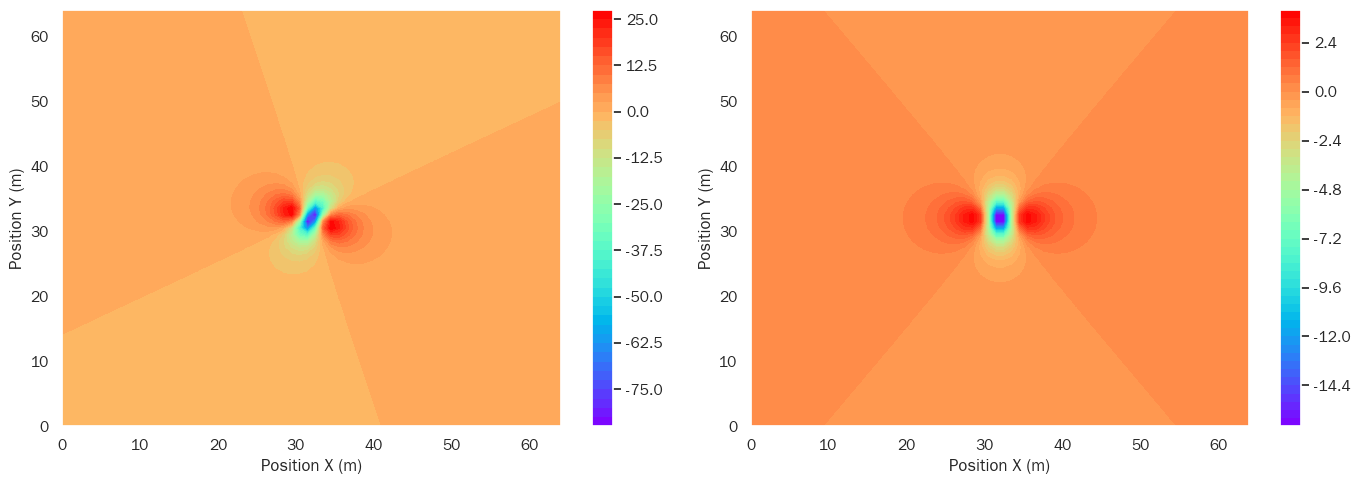

In [29]:
height_2 = 5
width_2 = 14
new_size =64
X = np.linspace(0, new_size, new_size)
Y = np.linspace(0, new_size, new_size)

model_to_plot_l = int(np.random.randint(
    0, X_data_array_with_noise.shape[0]-1, 1))
model_to_plot_l = 87
print(model_to_plot_l)

##############################

fig, axs = plt.subplots(1, 2, figsize=(width_2, height_2))

axs = axs.ravel()

cp_0 = axs[0].contourf(X, Y, X_train[n_i[model_to_plot_l],
                       :, :, 0], levels=50, cmap='rainbow')
axs[0].set_xlabel('Position X (m)')
# axs[0].set_xticks(np.arange(-25, 25, step=5))
axs[0].set_ylabel('Position Y (m)')
# axs[0].set_yticks(np.arange(-25, 25, step=5))
clb = plt.colorbar(cp_0, ax=axs[0])

cp_1 = axs[1].contourf(
    X, Y, X_train[n_i[model_to_plot_l+1], :, :, 0], levels=50, cmap='rainbow')
axs[1].set_xlabel('Position X (m)')
# axs[1].set_xticks(np.arange(-25, 25, step=5))
axs[1].set_ylabel('Position Y (m)')
# axs[1].set_yticks(np.arange(-25, 25, step=5))
clb = plt.colorbar(cp_1, ax=axs[1])


plt.tight_layout()

In [30]:
X_train = np.concatenate((X_train, X_data_array_with_noise), axis=0)
Y_pos_train = np.concatenate((Y_pos_train, Y_pos_train_noise), axis=0)

In [31]:
random_seed_3 = 128

X_train = shuffle(X_train[:], random_state=random_seed_3)
Y_pos_train = shuffle(Y_pos_train[:], random_state=random_seed_3)

In [32]:
print(X_train.shape, Y_pos_train.shape)
print(X_dev.shape, Y_pos_dev.shape)
print(X_test.shape, Y_pos_test.shape)

(816, 64, 64, 1) (816, 5)
(256, 64, 64, 1) (256, 5)
(52, 64, 64, 1) (52, 5)


In [33]:
N_total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]

print(f'Total number of examples : {N_total_examples}')
print(f'Train : {X_train.shape[0]}')
print(f'Dev : {X_dev.shape[0]}')
print(f'Test : {X_test.shape[0]}')

Total number of examples : 1124
Train : 816
Dev : 256
Test : 52


In [34]:
os.getcwd()

'/home/jiajianhao/文档/cnn/Magnetic_methods-master/YOLO/Synthetic_data/data/split'

In [41]:
def to_image(X_array):
    n,p,q,z = X_array.shape
    m = np.zeros([n,p,q,3])
    for bb_n_models in range(n):
        image = (X_array[bb_n_models,:,:,:] - np.min(X_array[bb_n_models,:,:,:])) / (np.max(X_array[bb_n_models,:,:,:]) - np.min(X_array[bb_n_models,:,:,:]))
        #Converting to rgb
        image_t = np.uint8(image * 255)      
        image_t = cv2.cvtColor(image_t,cv2.COLOR_GRAY2RGB)
        m[bb_n_models,:,:,:] = image_t
    return m

    

In [42]:
X_train = to_image(X_train)
X_dev = to_image(X_dev)
X_test = to_image(X_test)

In [43]:
# np.save(file="./data/Parameters_array_raw768.npy", arr=Parameters_array_raw)
np.save(file="./npy/X_train",arr=X_train)
np.save(file="./npy/X_dev",arr=X_dev)
np.save(file="./npy/X_test",arr=X_test)
np.save(file="./npy/Y_train",arr=Y_pos_train)
np.save(file="./npy/Y_dev",arr=Y_pos_dev)
np.save(file="./npy/Y_test",arr=Y_pos_test)